In [61]:
# change used width of browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
# import DBSCAN
# import packages
import pandas as pd
import re
import seaborn as sb
import matplotlib.pyplot as plt
import datetime
import json

from sklearn.manifold import TSNE as TSNE


In [2]:
df_joined = pd.read_csv("userclusterdata.csv")

In [200]:
df_small = df_joined.head(100000)

In [201]:
df_small = df_small.drop(columns="userId")

done


In [186]:
df_tsne = pd.read_csv("tsne_allgenres.csv",header=None)
df_pca = pd.read_csv("pca_allgenres.csv",header=None)

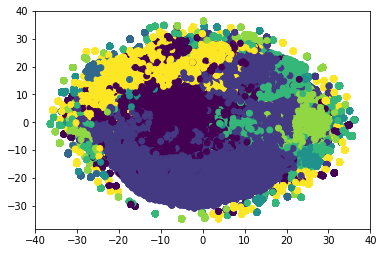

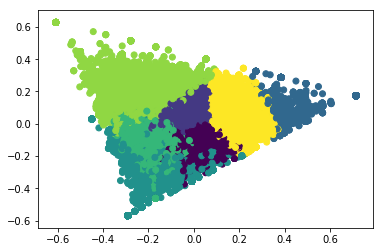

In [204]:
# import KMeans
from sklearn.cluster import KMeans

estimator = KMeans(n_clusters = 7)

# fit the model and return the clusters
labels = estimator.fit_predict(df_joined.drop(columns="userId"))
plt.scatter(df_tsne[0],df_tsne[1] ,c=labels)
plt.show()
plt.scatter(df_pca[0],df_pca[1] ,c=labels)
plt.show()

In [207]:
df_joined["clusters"] = labels
df_joined.head(100)

,userId,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,...,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie,clusters
0,1,0.083333,0.020000,0.020000,0.033333,0.000000,0.033333,0.120000,0.000000,0.000000,...,0.000000,0.033333,0.020000,0.0,0.153333,0.233333,0.033333,0.000000,0.0,1
1,2,0.049020,0.132353,0.000000,0.000000,0.049020,0.000000,0.102941,0.000000,0.039216,...,0.019608,0.019608,0.000000,0.0,0.034314,0.186275,0.000000,0.019608,0.0,1
2,3,0.114583,0.031250,0.125000,0.062500,0.000000,0.000000,0.135417,0.041667,0.000000,...,0.041667,0.000000,0.000000,0.0,0.000000,0.166667,0.000000,0.000000,0.0,0
3,4,0.081061,0.054545,0.041667,0.000000,0.000000,0.011364,0.126515,0.000000,0.015152,...,0.053030,0.041667,0.011364,0.0,0.084848,0.143939,0.026515,0.000000,0.0,1
4,5,0.126984,0.071429,0.203704,0.000000,0.055556,0.000000,0.126984,0.000000,0.015873,...,0.074074,0.037037,0.015873,0.0,0.000000,0.052910,0.037037,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,0.068841,0.019565,0.041304,0.000000,0.014493,0.000000,0.059420,0.014493,0.065217,...,0.036232,0.025362,0.008696,0.0,0.030435,0.188406,0.043478,0.014493,0.0,1
96,98,0.086817,0.067526,0.060494,0.016204,0.037037,0.010031,0.106878,0.010340,0.032959,...,0.058179,0.027006,0.013977,0.0,0.029938,0.137125,0.012346,0.008025,0.0,0
97,99,0.055556,0.111111,0.041667,0.000000,0.000000,0.000000,0.041667,0.000000,0.055556,...,0.000000,0.041667,0.000000,0.0,0.097222,0.111111,0.000000,0.055556,0.0,4
98,100,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.000000,0.000000,0.0,6


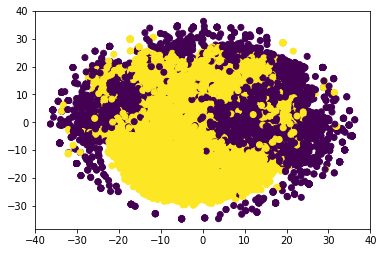

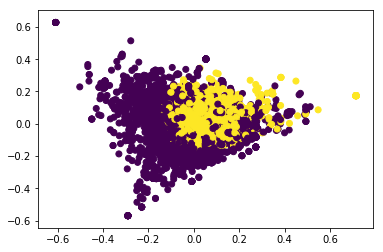

In [198]:
# create the clusterer
clusterer = DBSCAN(min_samples=75, eps=0.03, metric='cosine')
# create the clusters
clusters = clusterer.fit(df_small)
plt.scatter(df_tsne.head(10000)[0],df_tsne.head(10000)[1] ,c=clusters.labels_)
plt.show()
plt.scatter(df_pca.head(10000)[0],df_pca.head(10000)[1] ,c=clusters.labels_)
plt.show()

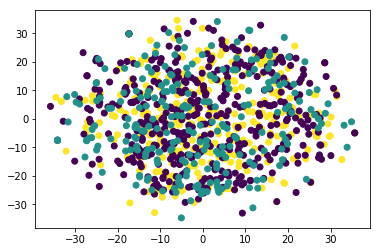

In [71]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters = 3, linkage='single', affinity='euclidean')
clusters = agg.fit_predict(df_small)
plt.scatter(df_tsne.head(1000)[0],df_tsne.head(1000)[1] ,c=clusters)
plt.show()

In [72]:
df_small["cluster"] = clusters
df_small

,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,...,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie,cluster
0,0.083333,0.020000,0.020000,0.033333,0.000000,0.033333,0.120000,0.000000,0.000000,0.216667,...,0.000000,0.033333,0.020000,0.000000,0.153333,0.233333,0.033333,0.000000,0.000000,2
1,0.049020,0.132353,0.000000,0.000000,0.049020,0.000000,0.102941,0.000000,0.039216,0.289216,...,0.019608,0.019608,0.000000,0.000000,0.034314,0.186275,0.000000,0.019608,0.000000,2
2,0.114583,0.031250,0.125000,0.062500,0.000000,0.000000,0.135417,0.041667,0.000000,0.281250,...,0.041667,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,2
3,0.081061,0.054545,0.041667,0.000000,0.000000,0.011364,0.126515,0.000000,0.015152,0.285606,...,0.053030,0.041667,0.011364,0.000000,0.084848,0.143939,0.026515,0.000000,0.000000,2
4,0.126984,0.071429,0.203704,0.000000,0.055556,0.000000,0.126984,0.000000,0.015873,0.182540,...,0.074074,0.037037,0.015873,0.000000,0.000000,0.052910,0.037037,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.094813,0.036197,0.053462,0.014493,0.031079,0.010064,0.070738,0.011675,0.039418,0.258017,...,0.051047,0.029147,0.008500,0.006844,0.019968,0.202381,0.020290,0.014493,0.004026,1
996,0.116667,0.100000,0.175000,0.000000,0.025000,0.000000,0.050000,0.000000,0.075000,0.166667,...,0.075000,0.000000,0.000000,0.000000,0.050000,0.116667,0.050000,0.000000,0.000000,1
997,0.061404,0.057018,0.039474,0.000000,0.013158,0.000000,0.070175,0.026316,0.065789,0.302632,...,0.061404,0.057018,0.000000,0.000000,0.057018,0.157895,0.013158,0.017544,0.000000,1
998,0.035714,0.000000,0.071429,0.071429,0.047619,0.000000,0.047619,0.047619,0.071429,0.154762,...,0.119048,0.071429,0.000000,0.000000,0.000000,0.035714,0.035714,0.047619,0.000000,1


In [96]:
# only retain top genre
df_small1 = df_small.drop(columns="cluster")

In [99]:
import numpy as np
df_small1.apply(lambda x: np.where(x < 0.15, 0,x))

,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.216667,0.0,0.0,0.0,0.0,0.0,0.153333,0.233333,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.289216,0.0,0.0,0.0,0.0,0.0,0.000000,0.186275,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.281250,0.0,0.0,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.285606,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.203704,0.0,0.0,0.0,0.0,0.0,0.0,0.182540,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.258017,0.0,0.0,0.0,0.0,0.0,0.000000,0.202381,0.0,0.0,0.0
996,0.0,0.0,0.175000,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
997,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.302632,0.0,0.0,0.0,0.0,0.0,0.000000,0.157895,0.0,0.0,0.0
998,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.154762,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


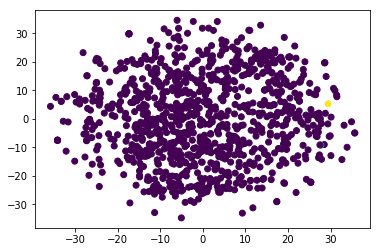

In [100]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters = 3, linkage='single', affinity='euclidean')
clusters = agg.fit_predict(df_small1)
plt.scatter(df_tsne.head(1000)[0],df_tsne.head(1000)[1] ,c=clusters)
plt.show()

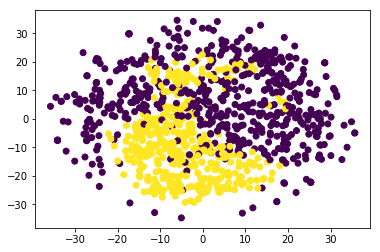

In [195]:
# create the clusterer
clusterer = DBSCAN(min_samples=25, eps=0.02, metric='cosine')
# create the clusters
clusters = clusterer.fit(df_small1)
plt.scatter(df_tsne.head(1000)[0],df_tsne.head(1000)[1] ,c=clusters.labels_)
plt.show()

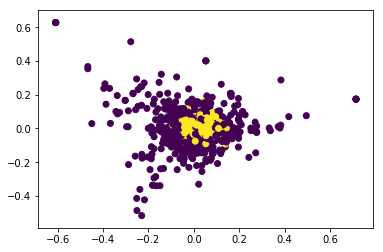

In [196]:
plt.scatter(df_pca.head(1000)[0],df_pca.head(1000)[1] ,c=clusters.labels_)
plt.show()